In [2]:
# Install dependencies (if needed)
# !pip install medmnist timm wandb ujson

# Imports
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import ujson as json
from tqdm import tqdm
import random


In [3]:
# Load config
with open("organamnist4/config.json", 'r') as f:
    config = json.load(f)

num_clients = config["num_clients"]
num_classes = config["num_classes"]
print("Clients:", num_clients, "Classes:", num_classes)


Clients: 4 Classes: 11


In [4]:
class NpzClientDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file, allow_pickle=True)['data'].item()
        self.x = torch.tensor(data['x']).float()
        self.y = torch.tensor(data['y']).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [5]:
client_train_loaders = []
client_test_loaders = []

for cid in range(num_clients):
    train_dataset = NpzClientDataset(f"organamnist4/train/{cid}.npz")
    test_dataset  = NpzClientDataset(f"organamnist4/test/{cid}.npz")
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

    client_train_loaders.append(train_loader)
    client_test_loaders.append(test_loader)

print("Data loading done ✅")


Data loading done ✅


In [6]:
import timm

# Define a basic Vision Transformer
def get_vit_model():
    model = timm.create_model("vit_small_patch16_224", pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)  # Update for OrganAMNIST
    return model


In [7]:
class PrefixEncoder(nn.Module):
    def __init__(self, prefix_length, embed_dim, num_layers):
        super().__init__()
        self.prefix_length = prefix_length
        self.prefix_tokens = nn.Parameter(torch.randn(num_layers, prefix_length, embed_dim))
    
    def forward(self, B):
        # repeat across batch dim
        return self.prefix_tokens.unsqueeze(1).repeat(1, B, 1, 1)  # [layers, batch, prefix_len, dim]


In [8]:
class FedPerfixViT(nn.Module):
    def __init__(self, base_model, prefix_length=5):
        super().__init__()
        self.base = base_model
        self.prefix_len = prefix_length
        self.embed_dim = base_model.blocks[0].attn.qkv.in_features
        self.num_layers = len(base_model.blocks)

        # Each client will own this part independently
        self.prefix_encoder = PrefixEncoder(prefix_length, self.embed_dim, self.num_layers)

    def forward(self, x, client_id=None):
        B = x.size(0)
        x = self.base.patch_embed(x)  # [B, num_patches, dim]
        cls_token = self.base.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        x = self.base.pos_drop(x + self.base.pos_embed)

        # Get per-layer prefix tokens
        prefixes = self.prefix_encoder(B)  # [layers, B, prefix_len, dim]

        # Apply transformer blocks + insert prefix
        for i, blk in enumerate(self.base.blocks):
            # Insert prefix at this layer
            px = prefixes[i]  # [B, prefix_len, dim]
            x = torch.cat([px, x], dim=1)
            x = blk(x)

        x = self.base.norm(x)
        cls_output = x[:, self.prefix_len, :]  # use position after prefix
        return self.base.head(cls_output)


In [9]:
prefix_len = 5
client_models = []

for cid in range(num_clients):
    base = get_vit_model()
    model = FedPerfixViT(base_model=base, prefix_length=prefix_len)
    client_models.append(model)


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [10]:
def freeze_base(model):
    for name, param in model.named_parameters():
        if not name.startswith("prefix_encoder"):
            param.requires_grad = False


In [11]:
for model in client_models:
    freeze_base(model)

In [12]:
def local_train(model, train_loader, epochs=1, lr=0.001, device='cpu'):
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.prefix_encoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


In [17]:
def test_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    return acc*100


In [18]:
client_id = 0
model = client_models[client_id]
train_loader = client_train_loaders[client_id]
test_loader = client_test_loaders[client_id]

print("Before training:", test_model(model, test_loader))
local_train(model, train_loader, epochs=2, lr=0.001, device='cpu')
print("After training:", test_model(model, test_loader))


Before training: 23.4375
Epoch 1 Loss: 2.2183
Epoch 2 Loss: 2.0920
After training: 35.9375


In [19]:
def get_base_state(model):
    return {k: v.cpu().clone() for k, v in model.state_dict().items() if not k.startswith("prefix_encoder")}

In [20]:
def fedavg(base_state_list):
    avg_state = {}
    num_clients = len(base_state_list)

    for key in base_state_list[0].keys():
        avg_state[key] = sum(client_state[key] for client_state in base_state_list) / num_clients

    return avg_state


In [21]:
def load_base_state(model, base_state):
    model_state = model.state_dict()
    for k in base_state.keys():
        if k in model_state:
            model_state[k] = base_state[k].clone()
    model.load_state_dict(model_state)


In [22]:
def fedperfix_train(num_rounds=3, local_epochs=1, lr=0.001, device='cpu'):
    for rnd in range(num_rounds):
        print(f"\n🌐 Round {rnd + 1}")
        base_state_list = []

        # Local training per client
        for cid in range(num_clients):
            print(f"\nClient {cid} training...")
            model = client_models[cid]
            local_train(model, client_train_loaders[cid], epochs=local_epochs, lr=lr, device=device)
            base_state = get_base_state(model)
            base_state_list.append(base_state)

        # FedAvg across base models
        print("\n🔄 Aggregating shared base model...")
        avg_state = fedavg(base_state_list)

        # Load shared base into all clients (prefix untouched)
        for cid in range(num_clients):
            load_base_state(client_models[cid], avg_state)

        # Evaluation after round
        round_accs = []
        for cid in range(num_clients):
            acc = test_model(client_models[cid], client_test_loaders[cid], device=device)
            round_accs.append(acc)
            print(f"Client {cid} Test Acc: {acc:.2f}")
        
        print(f"📈 Round {rnd + 1} Average Accuracy: {np.mean(round_accs):.4f}")


In [23]:
fedperfix_train(num_rounds=3, local_epochs=1, lr=0.001, device='cpu')


🌐 Round 1

Client 0 training...
Epoch 1 Loss: 1.9960

Client 1 training...
Epoch 1 Loss: 2.9728

Client 2 training...
Epoch 1 Loss: 2.8448

Client 3 training...
Epoch 1 Loss: 3.0856

🔄 Aggregating shared base model...
Client 0 Test Acc: 14.06
Client 1 Test Acc: 2.44
Client 2 Test Acc: 0.00
Client 3 Test Acc: 32.84
📈 Round 1 Average Accuracy: 12.3343

🌐 Round 2

Client 0 training...
Epoch 1 Loss: 2.3972

Client 1 training...
Epoch 1 Loss: 2.5992

Client 2 training...
Epoch 1 Loss: 2.4225

Client 3 training...
Epoch 1 Loss: 2.3935

🔄 Aggregating shared base model...
Client 0 Test Acc: 18.75
Client 1 Test Acc: 2.44
Client 2 Test Acc: 0.00
Client 3 Test Acc: 32.84
📈 Round 2 Average Accuracy: 13.5062

🌐 Round 3

Client 0 training...
Epoch 1 Loss: 2.2963

Client 1 training...
Epoch 1 Loss: 2.5322

Client 2 training...
Epoch 1 Loss: 2.3138

Client 3 training...
Epoch 1 Loss: 2.2902

🔄 Aggregating shared base model...
Client 0 Test Acc: 28.12
Client 1 Test Acc: 2.44
Client 2 Test Acc: 18.75
C

In [25]:
def fedperfix_train(num_rounds=3, local_epochs=1, lr=0.001, device='cpu'):
    history = {
        'rounds': [],
        'client_accs': [],  # list of lists
        'avg_accs': []
    }

    for rnd in range(num_rounds):
        print(f"\n🌐 Round {rnd + 1}")
        base_state_list = []

        # Local training
        for cid in range(num_clients):
            print(f"\nClient {cid} training...")
            model = client_models[cid]
            local_train(model, client_train_loaders[cid], epochs=local_epochs, lr=lr, device=device)
            base_state = get_base_state(model)
            base_state_list.append(base_state)

        # Aggregation
        avg_state = fedavg(base_state_list)
        for cid in range(num_clients):
            load_base_state(client_models[cid], avg_state)

        # Evaluation
        round_accs = []
        for cid in range(num_clients):
            acc = test_model(client_models[cid], client_test_loaders[cid], device=device)
            round_accs.append(acc)
            print(f"Client {cid} Test Acc: {acc:.4f}")

        avg_acc = np.mean(round_accs)
        print(f"📈 Round {rnd + 1} Avg Accuracy: {avg_acc:.4f}")

        # Save history
        history['rounds'].append(rnd + 1)
        history['client_accs'].append(round_accs)
        history['avg_accs'].append(avg_acc)

    return history


In [26]:
history = fedperfix_train(num_rounds=3, local_epochs=1, lr=0.001, device='cpu')


🌐 Round 1

Client 0 training...
Epoch 1 Loss: 2.2053

Client 1 training...
Epoch 1 Loss: 2.4421

Client 2 training...
Epoch 1 Loss: 2.2260

Client 3 training...
Epoch 1 Loss: 2.1554
Client 0 Test Acc: 43.7500
Client 1 Test Acc: 2.4390
Client 2 Test Acc: 27.5000
Client 3 Test Acc: 32.8358
📈 Round 1 Avg Accuracy: 26.6312

🌐 Round 2

Client 0 training...
Epoch 1 Loss: 2.1264

Client 1 training...
Epoch 1 Loss: 2.3781

Client 2 training...
Epoch 1 Loss: 2.1519

Client 3 training...
Epoch 1 Loss: 2.0495
Client 0 Test Acc: 40.6250
Client 1 Test Acc: 14.6341
Client 2 Test Acc: 27.5000
Client 3 Test Acc: 32.8358
📈 Round 2 Avg Accuracy: 28.8987

🌐 Round 3

Client 0 training...
Epoch 1 Loss: 2.0498

Client 1 training...
Epoch 1 Loss: 2.3266

Client 2 training...
Epoch 1 Loss: 2.0825

Client 3 training...
Epoch 1 Loss: 1.9851
Client 0 Test Acc: 39.0625
Client 1 Test Acc: 51.2195
Client 2 Test Acc: 28.7500
Client 3 Test Acc: 32.8358
📈 Round 3 Avg Accuracy: 37.9670


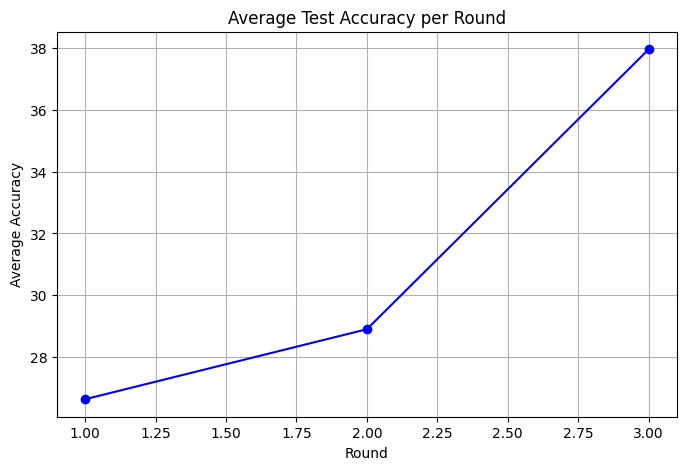

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(history['rounds'], history['avg_accs'], marker='o', color='blue')
plt.title("Average Test Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Average Accuracy")
plt.grid(True)
plt.show()

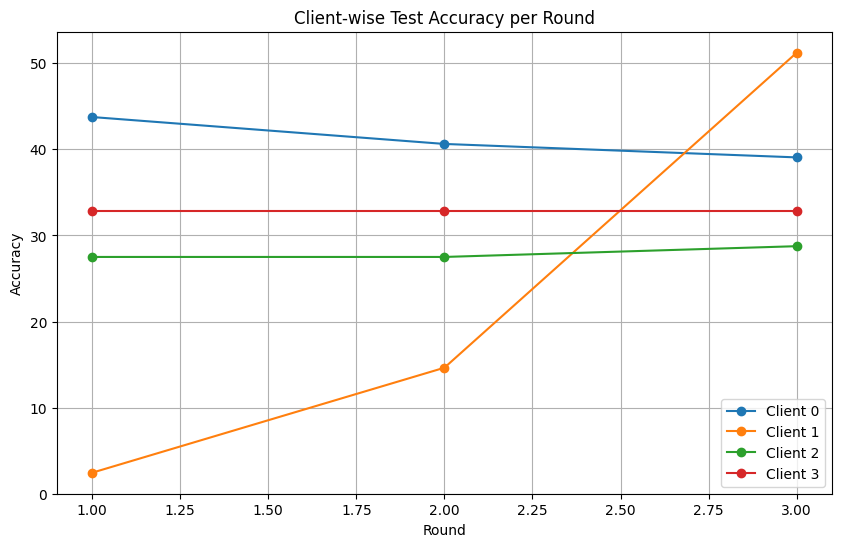

In [28]:
plt.figure(figsize=(10, 6))
for cid in range(num_clients):
    client_acc = [r[cid] for r in history['client_accs']]
    plt.plot(history['rounds'], client_acc, marker='o', label=f'Client {cid}')

plt.title("Client-wise Test Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
